In [81]:
"""
Graph Model package to implement and vizualize green growth models
"""
__author__ = 'Simon'

import networkx as nx
import graphviz
import logging
from functools import partial, reduce


logging.basicConfig(filename='example.log', level=logging.DEBUG)

draw_properties = {
    'fillcolor': {'input': '#e76f51',
                  'parameter': '#e9c46a',
                  'variable': '#f4a261',
                  'output': '#2a9d8f',
                  'computationnal': '#e76f51'},
    'fontcolor': {'input': '#eeeeee',
                  'parameter': '#eeeeee',
                  'variable': '#eeeeee',
                  'output': '#eeeeee',
                  'computationnal': '#000000'},
    'color': {'input': '#eeeeee',
              'parameter': '#eeeeee',
              'variable': '#eeeeee',
              'output': '#eeeeee',
              'computationnal': '#A9A9A9'},
    'style': {'input': 'filled',
              'parameter': 'filled',
              'variable': 'filled',
              'output': 'filled',
              'computationnal': ''},
}


class GraphModel(nx.DiGraph):
    '''GraphModel allows to write a model as a Graph.

    It herites from nx.Digraph class.

    Attributes:
        node_ordering (list): Topological order of the computationnal nodes.
    '''

    def __init__(self, graph_specifications):
        '''Initialize a graph from a specification.

        Args:
            graph_specifications(list): List of node specification.
        '''
        super(GraphModel, self).__init__()
        self.make_graph(graph_specifications)
        self.node_ordering = self.get_computational_nodes_ordering()
        self.model_function = model_function(self)
        self.graph_specifications = graph_specifications
        self.summary_df = self.summary()

    def checks(self, nodes, edges):
        '''Checks if the graph is well defined.

        Args:
            nodes (List): list of nodes.
            edges (List): list of edges.
        '''
        node_set = set([n[0] for n in nodes])
        edge_set = set([e[0] for e in edges])
        diff = edge_set - node_set
        assert edge_set <= node_set, f"{diff} is used in a computation but is not defined in a node"

    def make_graph(self, graph_nodes):
        '''Make the nx.Digraph object.

        Args:
            graph_nodes(List): list of formatted nodes

        Returns:
            None, Initialize the graph object.
        '''
        nodes, edges = GraphParser().parse(graph_nodes)
        self.checks(nodes, edges)
        self.add_nodes_from(nodes)
        self.add_edges_from(edges)
        return None

    def get_node_by_type(self, node_type):
        '''Returns the node of a given node_type'''
        return [node_id for node_id, node in self.nodes.items() if node['type'] == node_type]

    def inputs_(self):
        return self.get_node_by_type('input')

    def outputs_(self):
        return self.get_node_by_type('output')

    def variables_(self):
        return self.get_node_by_type('variable')

    def parameters_(self):
        return self.get_node_by_type('parameter')


    def summary(self):
        '''Return a pandas dataframe to summarize the node of the graph as specified in the graph_specification.

        TO IMPROVE.
        '''
        summary_df = pd.DataFrame()

        for node in self.graph_specifications:

            if 'computation' in node:
                comp = node['computation']['name']
            else:
                comp = np.nan

            row = pd.DataFrame({'name': node['name'] ,'type': node['type'], 'unit': node['unit'], 'computation':comp}, index=[node['id']])
            summary_df = summary_df.append(row)

        summary_df.index.name = 'id'
        return summary_df

    def get_computational_nodes_ordering(self):
        '''Returns the sorted list of computationnal nodes.

        Returns:
            ordering(list): List of ordered computationnal nodes.
        '''
        ordering = [node for node in nx.topological_sort(self) if '_comp' in node]
        return ordering

    def run(self, X):
        '''Run the GraphModel given inputs and parameters.

        Args:
            X(dict): dictionnary of input and parameters.

        Returns:
            X(dict): inputs, variables and outputs of the graph.
        '''
        X = self.model_function(X)
        return X

    def draw(self, draw_properties=draw_properties):
        '''Draw the graph.

        Args:
            draw_properties(dict): dictionnary of properties for the graph plot.
        '''
        return GraphDrawer(draw_properties).draw(self)

    def draw_computation(self, inputs_parameters, draw_properties=draw_properties):
        '''Draw the graph with the computated values.

        Args:
            draw_properties(dict): dictionnary of properties for the graph plot.
            inputs(dict): dictionnary of input values.
            parameters(dict): dictionnary of parameter values.
        '''
        return GraphDrawer(draw_properties).draw_computation(self, inputs_parameters)


class GraphDrawer():
    '''A class to draw the Graph models.

    Attributes:
        draw_properties(dict): dictionnary of properties for the graph plot.
    '''

    def __init__(self, draw_properties):
        '''Initialize the GraphDrawer

        Attributes:
            draw_properties(dict): dictionnary of properties for the graph plot.
        '''
        self.draw_properties = draw_properties
        return None

    def get_node_label(self, node):
        '''Get the label of a given node.

        TO CLEAN UP !!!

        Args:
            node(node): Node of the graph.

        Returns:
            label(str): A label for the node.
        '''
        node_id, label, node_type = node[0], node[1]['name'], node[1]['type']

        if node_type != 'computationnal':
            label = f"{label} \n ({node_id})"
            if 'value' in node[1]:
                value = node[1]['value']
                label = f"{label} \n {value}"
            if 'unit' in node[1]:
                unit = node[1]['unit']
                label = f"{label} \n {unit}"
        return label

    def draw_node(self, dot, node, draw_properties):
        '''Draw a node of the graph.

        TO CLEAN UP !!!

        Args:
            dot(dot): dot object for drawing.
            node(node): Node of the graph.
            draw_properties(dict): dictionnary of properties for the graph plot.

        Returns:
            None, updates the dot object.
        '''
        label = self.get_node_label(node)
        node_type = node[1]['type']
        dot.node(node[0], node[0], {"shape": "rectangle",
                                    "peripheries": "1",
                                    'label': label,
                                    'fillcolor': draw_properties['fillcolor'][node_type],
                                    'style': draw_properties['style'][node_type],
                                    'color': draw_properties['color'][node_type],
                                    'fontcolor': draw_properties['fontcolor'][node_type],
                                    'fontname': 'roboto'
                                    }
                 )

    def draw_edge(self, dot, a, b, draw_properties):
        '''Draw an edge of the graph.

        Args:
            dot(dot): dot object for drawing.
            a(node): Node of the graph.
            b(node): Node of the graph.
            draw_properties(dict): dictionnary of properties for the graph plot.
        '''
        dot.edge(a, b, color='#A9A9A9')

    def draw(self, G):
        '''Draw a full Graph Model

        Args:
            G(GraphModel): A graph model.

        Returns:
            dot(obj): The plot object of the graph.
        '''
        draw_properties = self.draw_properties
        dot = graphviz.Digraph(graph_attr={'splines': 'ortho'})
        for node in G.nodes(data=True):
            self.draw_node(dot, node, draw_properties)
        for a, b in G.edges:
            self.draw_edge(dot, a, b, draw_properties)
        return dot

    def draw_computation(self, G, inputs_parameters):
        '''Draw a full Graph Model with the computed values:

        Args:
            G(GraphModel): A graph model.
            inputs(dict): dictionnary of input values.
            parameters(dict): dictionnary of parameter values.

        Returns:
            dot(obj): The plot object of the graph.
        '''
        X = G.run(inputs_parameters)
        for node_id in X:
            G.nodes[node_id]['value'] = X[node_id]
        dot = self.draw(G)

        for node_id in X:  # Ugly, need to find better option for drawing
            del G.nodes[node_id]['value']

        return dot


class GraphParser():
    '''A class to parse the specification of a graph
    '''

    def __init__(self):
        '''
        Initialize a parser.
        '''
        return None

    def parse_node(self, raw_node):
        '''Parse a node.

        Args:
            raw_node(dict): raw node given in graph_specifications.

        Returns:
            node(node): A formatted non computationnal node.
        '''
        node = (raw_node['id'], {k: raw_node[k] for k in ('type', 'unit', 'name')})
        return node

    def parse_computational_node(self, raw_node):
        '''Parse a computationnal node.

        Args:
            raw_node(dict): raw node given in graph_specifications.

        Returns:
            node(node): A formatted computationnal node
        '''
        node_id = f"{raw_node['id']}_comp"
        node_param = {}
        node_param['formula'] = raw_node['computation']['formula']
        node_param['name'] = raw_node['computation']['name']
        node_param['out'] = raw_node['id']
        node_param['in'] = raw_node['in']
        node_param['type'] = 'computationnal'
        node = (node_id, node_param)
        return node

    def parse_computational_edges(self, comp_node):
        '''Parse edges from and to a computationnal node.

        Args:
            comp_node(dict): a computationnal node.

        Returns:
            edges(list): list of edges in the graph.
        '''
        edges = []
        for in_node in comp_node[1]['in']:
            edge = (in_node, comp_node[0])
            edges.append(edge)
        edges.append((comp_node[0], comp_node[0].split('_comp')[0]))
        return edges

    def parse(self, graph_specifications):
        '''Parse the graph specification

        Args:
            graph_specifications(List): list of nodes

        Returns:
            nodes(List): list of parsed nodes.
            egdes(List): list of parsed edges.
        '''
        edges, nodes = [], []
        for raw_node in graph_specifications:
            node = self.parse_node(raw_node)
            nodes.append(node)

            if 'computation' in raw_node:
                node = self.parse_computational_node(raw_node)
                nodes.append(node)

                comp_edges = self.parse_computational_edges(node)
                edges += comp_edges

        return nodes, edges


def compose(*functions):
    return reduce(lambda f, g: lambda x: f(g(X=x)), functions, lambda x: x)


def node_function(node, X):
    X = X.copy()
    function, out_node = node['formula'], node['out']
    X[out_node] = function(X)
    return X


def model_function(G):
    '''The function computed by the model'''
    functions_list = [partial(node_function, node=G.nodes[node_id])
                      for node_id in G.node_ordering[::-1]]
    return compose(*functions_list)


In [82]:
"""
Freshwater Available

Short description of input/outputs assumptions etc etc
"""

FreshwaterAvailableNodes = [
    {'type': 'input',
     'unit': 'mm/year',
        'name': 'Precipitation',
     'id': 'P'},
    {'type': 'input',
     'unit': 'mm/year',
        'name': 'Evapotranspiration',
     'id': 'ET'},
    {'type': 'input',
     'unit': 'ha',
        'name': 'Catchment Size',
     'id': 'A'},
    {'type': 'variable',
     'name': 'Change in Surface Water Storage',
     'unit': 'mm/year',  # need to look into conversion of units think it would be m3/year
     'in': ['P', 'ET', 'A'],
     'computation': {'name': '(P - ET)*A', 'formula': lambda X: (X['P'] - X['ET']) * X['A']},
     'id': 'S'},

    # Renewable Water Resources
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Surface Water',
     'id': 'SW'},
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Groundwater Water',
     'id': 'GW'},
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Overlap (Surface - Groundwater)',
     'id': 'Overlap'},
    {'type': 'variable',
     'name': 'Internal Renewable Water Resources',
     'unit': 'm3/year',
     'in': ['SW', 'GW', 'Overlap', 'S'],
     'computation': {'name': 'GW + (SW + S) - Overlap', 'formula': lambda X: X['GW'] + (X['SW'] - X['S']) - X['Overlap']},
     'id': 'IRWR'},
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'External Renewable Water Resources',
     'id': 'ERWR'},
    {'type': 'variable',
     'name': 'Total Renewable Freshwater',
     'unit': 'm3/year',
     'in': ['IRWR', 'ERWR'],
     'computation': {'name': 'IRWR + ERWR', 'formula': lambda X: X['IRWR'] + X['ERWR']}, 'id': 'TRF'},

    # Non conventional water
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Desalination Water',
     'id': 'DW'},
    {'type': 'parameter',
        'unit': 'm3/year',
        'name': 'Treated Wastewater',
        'id': 'TW'},
    {'type': 'variable',
     'name': 'Total Non Conventional Water',
     'unit': 'm3/year',
     'in': ['DW', 'TW'],
     'computation': {'name': 'DW + TW', 'formula': lambda X: X['DW'] + X['TW']}, 'id': 'TNCW'},
    {'type': 'variable',
        'name': 'Total Freshwater Available',
        'unit': 'm3/year',
        'in': ['TRF', 'TNCW'],
        'computation': {'name': 'TRF + TNCW', 'formula': lambda X: X['TRF'] + X['TNCW']}, 'id': 'TFA'},

    # calculation of EW 2
    # input from water use model
    {'type': 'input',
        'unit': 'm3/year',
        'name': 'Total Water Withdrawal',
     'id': 'TWW'},
    {'type': 'parameter',
     'unit': 'm3/year',
        'name': 'Environmental Flow Requirement',
     'id': 'EFR'},

    # inclusion of both natural and non-conventional water sources
    {'type': 'output',
     'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
     'unit': '%',
     'in': ['TFA', 'TWW', 'EFR'],
     'computation': {'name': 'TWW/(TFA-EFR)*100', 'formula': lambda X: X['TWW'] / (X['TFA'] - X['EFR']) * 100}, 'id': 'EW2'},

    # only natural water sources
    {'type': 'output',
     'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
     'unit': '%',
     'in': ['TRF', 'TWW', 'EFR'],
     'computation': {'name': 'TWW/(TRF-EFR)*100', 'formula': lambda X: X['TWW'] / (X['TRF'] - X['EFR']) * 100}, 'id': 'Natural EW2'},

]

model = GraphModel(FreshwaterAvailableNodes)#.draw()


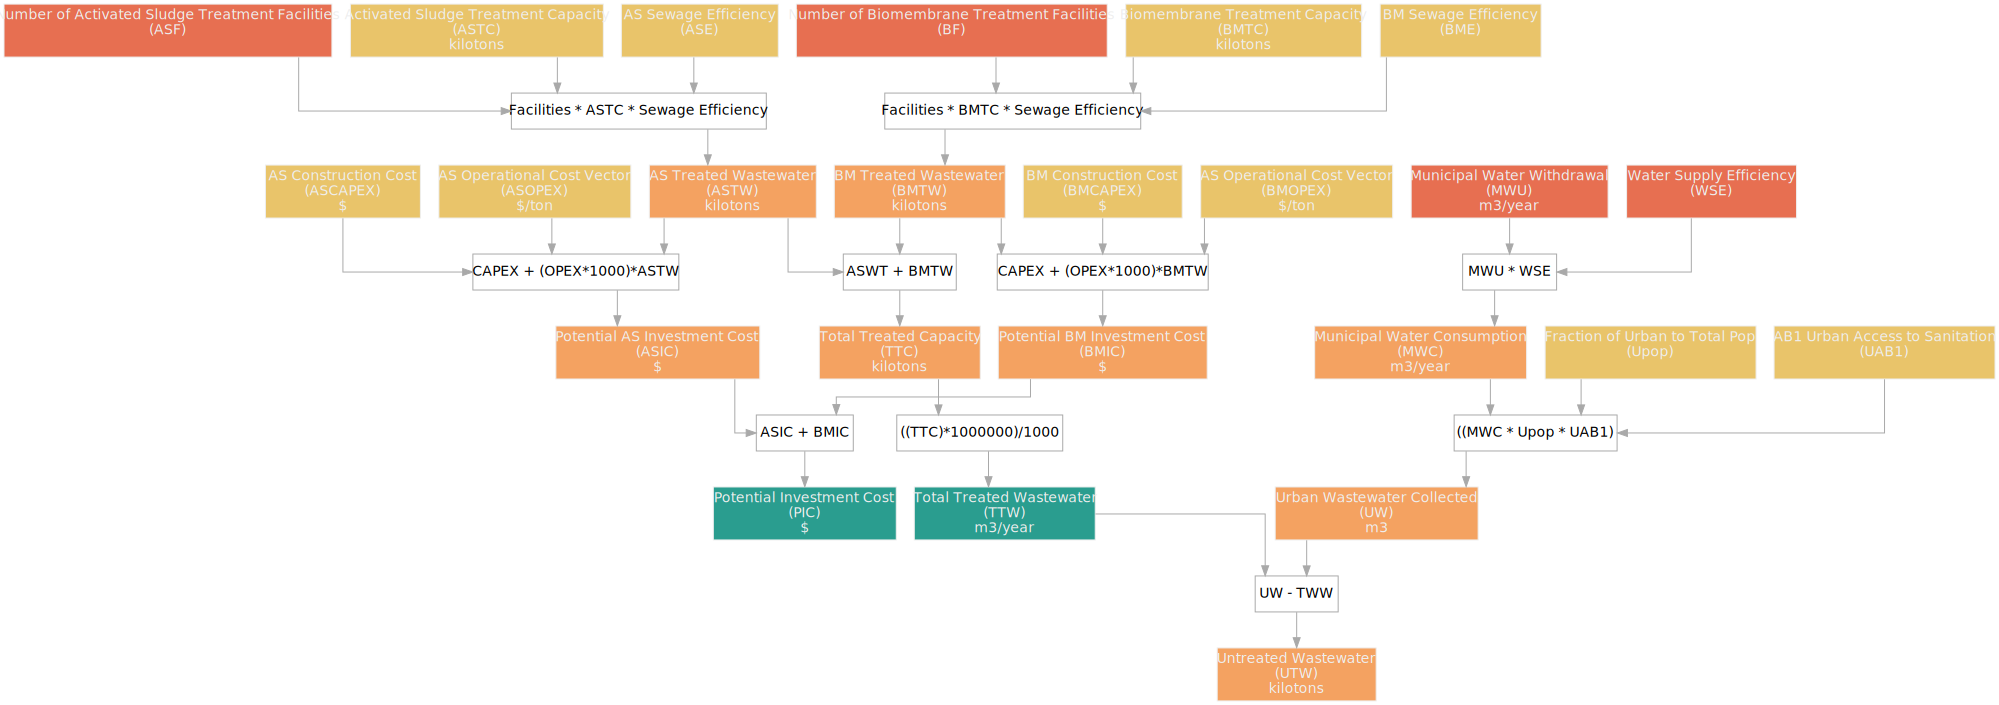

In [83]:
"""
Municipal Water

Short description of input/outputs assumptions etc etc
"""

MunicipalWaterNodes = [
    {'type': 'input',
     'name': 'Municipal Water Withdrawal',  # should be connecting to MWU variable from first water use model
     'unit': 'm3/year',
     'id': 'MWU'},

    {'type': 'input',
     'name': 'Water Supply Efficiency',  # can also be a parameter if we want to keep constant
     'unit': '',
     'id': 'WSE'},

    {'type': 'variable',
     'name': 'Municipal Water Consumption',
     'unit': 'm3/year',
     'in': ['MWU', 'WSE'],
     'computation': {'name': 'MWU * WSE', 'formula': lambda X: X['MWU'] * X['WSE']}, 'id': 'MWC'},

    # Identifying proportion of urban population with sanitation
    {'type': 'parameter',
     'name': 'Fraction of Urban to Total Pop',
     'unit': '',
     'id': 'Upop'},

    {'type': 'parameter',  # should be the output value from the AB1 indicator model
     'name': 'AB1 Urban Access to Sanitation',
     'unit': '',
     'id': 'UAB1'},

    {'type': 'variable',
     # current only consider wastewater from urban areas, could include rural by using same methodology above
     'name': ' Urban Wastewater Collected',
     'unit': 'm3',
     'in': ['MWC', 'Upop', 'UAB1'],
     'id': 'UW',
     'computation': {'name': '((MWC * Upop * UAB1)', 'formula': lambda X: X['MWC'] * X['Upop'] * X['UAB1']}},

    # Wastewater treatment scenario
    {'type': 'input',
     'name': 'Number of Activated Sludge Treatment Facilities',
     'unit': '',
     'id': 'ASF'},
    {'type': 'parameter',
     'name': 'Activated Sludge Treatment Capacity',
     'unit': 'kilotons',
     'id': 'ASTC'},
    {'type': 'parameter',
     'name': 'AS Sewage Efficiency',
     'unit': '',
     'id': 'ASE'},
    {'type': 'variable',
     'name': 'AS Treated Wastewater',
     'unit': 'kilotons',
     'in': ['ASF', 'ASTC', 'ASE'],
     'id': 'ASTW',
     'computation': {'name': 'Facilities * ASTC * Sewage Efficiency ', 'formula': lambda X: X['ASF'] * X['ASTC'] * X['ASE']}},

    {'type': 'input',
     'name': 'Number of Biomembrane Treatment Facilities',
     'unit': '',
     'id': 'BF'},
    {'type': 'parameter',
     'name': 'Biomembrane Treatment Capacity',
     'unit': 'kilotons',
     'id': 'BMTC'},
    {'type': 'parameter',
     'name': 'BM Sewage Efficiency',
     'unit': '',
     'id': 'BME'},
    {'type': 'variable',
     'name': 'BM Treated Wastewater',
     'unit': 'kilotons',
     'in': ['BF', 'BMTC', 'BME'],
     'id': 'BMTW',
     'computation': {'name': 'Facilities * BMTC * Sewage Efficiency', 'formula': lambda X: X['BF'] * X['BMTC'] * X['BME']}},

    {'type': 'variable',
     'name': 'Total Treated Capacity',
     'unit': 'kilotons',
     'in': ['ASTW', 'BMTW'],
     'id': 'TTC',
     'computation': {'name': 'ASWT + BMTW', 'formula': lambda X: X['ASTW'] + X['BMTW']}},


    # converting from kiloton -> kg -> m3 - this will be the input for the Total Treated Wastewater in the Freshwater Availability part of the model
    {'type': 'output',
     'name': 'Total Treated Wastewater',
     'unit': 'm3/year',
     'in': ['TTC'],
     'id': 'TTW',
     'computation': {'name': '((TTC)*1000000)/1000', 'formula': lambda X: X['TTC'] * 1000000 / 1000}},

    # amount of investment required per technology
    {'type': 'parameter',
     'name': 'AS Construction Cost',
     'unit': '$',
     'id': 'ASCAPEX'},

    {'type': 'parameter',
     'name': 'AS Operational Cost Vector',
     'unit': '$/ton',
     'id': 'ASOPEX'},

    {'type': 'variable',
     'name': 'Potential AS Investment Cost',
     'unit': '$',
     'in': ['ASCAPEX', 'ASOPEX', 'ASTW'],
     'id': 'ASIC',
     'computation': {'name': 'CAPEX + (OPEX*1000)*ASTW', 'formula': lambda X: X['ASCAPEX'] + X['ASOPEX'] * 1000 * X['ASTW']}},

    {'type': 'parameter',
        'name': 'BM Construction Cost',
        'unit': '$',
        'id': 'BMCAPEX'},
    {'type': 'parameter',
     'name': 'AS Operational Cost Vector',
     'unit': '$/ton',
     'id': 'BMOPEX'},
    {'type': 'variable',
     'name': 'Potential BM Investment Cost',
     'unit': '$',
     'in': ['BMCAPEX', 'BMOPEX', 'BMTW'],
     'id': 'BMIC',
     'computation': {'name': 'CAPEX + (OPEX*1000)*BMTW', 'formula': lambda X: X['BMCAPEX'] + X['BMOPEX'] * 1000 * X['BMTW']}},

    {'type': 'output',
     'name': 'Potential Investment Cost',
     'unit': '$',
     'in': ['ASIC', 'BMIC'],
     'id': 'PIC',
     'computation': {'name': 'ASIC + BMIC', 'formula': lambda X: X['ASIC'] + X['BMIC']}},

    # amount of untreated wastewater and link to DALY
    {'type': 'variable',
     'name': 'Untreated Wastewater',
     'unit': 'kilotons',
     'in': ['TTW', 'UW'],
     'id': 'UTW',
     'computation': {'name': 'UW - TWW', 'formula': lambda X: X['UW'] - X['TTW']}},

    # for further discussion
    # how untreated wastewater increases the burden of disease -> social cost of pollution
    # comparing the potential investment costs to the social benefit of reducing wastewater pollution.
]

GraphModel(MunicipalWaterNodes).draw()

In [ ]:
GraphModel(MunicipalWaterNodes + FreshwaterAvailableNodes)